# Assignment 18
--------------------------------------------------------------------------------

### In this assignment we are going to implement SuffleNet architecture with tfRecord. Also, we will try to visualize the images.

###To achieve this goal let's all required libraries:

In [1]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Now, let's connect to google drive to download CIFAR10 tfRecorded files.

In [2]:
!pip install -U -q PyDrive
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /tmp/colab_util_repo
!mv /tmp/colab_util_repo/colab_util.py colab_util.py 
!rm -r /tmp/colab_util_repo
from colab_util import *
drive_handler = GoogleDriveHandler()

Cloning into '/tmp/colab_util_repo'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


In [0]:
def Download_File_from_Drive(FileName,DriveFilepath):
  drive_handler.download(FileName, target_path=DriveFilepath)

def Upload_Images_to_Drive(FileName,TargetDrivePath):
  drive_handler.upload(FileName, parent_path=TargetDrivePath)  

In [4]:
try:
  from generate_tfrecords import CIFAR_TFRecords
  from process_tfrecords import create_Train_dataset, create_Test_dataset, parser_test, convert_to_numpy
  # from visualization import plot_image
except:
  !git clone https://github.com/santuhazra1/DEEP_LEARNING_LIBRARY.git /tmp/DEEP_LEARNING_LIBRARY
  !mv /tmp/DEEP_LEARNING_LIBRARY/TF_Records/generate_tfrecords.py generate_tfrecords.py
  !mv /tmp/DEEP_LEARNING_LIBRARY/TF_Records/process_tfrecords.py process_tfrecords.py
  # !mv /tmp/DEEP_LEARNING_LIBRARY/Visualization/visualization.py visualization.py
  !rm -r /tmp/DEEP_LEARNING_LIBRARY
  from generate_tfrecords import CIFAR_TFRecords
  from process_tfrecords import create_Train_dataset, create_Test_dataset, parser_test, convert_to_numpy
  # from visualization import plot_image

Cloning into '/tmp/DEEP_LEARNING_LIBRARY'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 59 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (59/59), done.


In [5]:
try:
  Download_File_from_Drive('eval.tfrecords','EVA_Phase_1/CIFAR10_Data/eval.tfrecords')
  Download_File_from_Drive('train.tfrecords','EVA_Phase_1/CIFAR10_Data/train.tfrecords')
  print('Download Successful')
except:
  data_dir = '/content/'
  CIFAR_TFRecords(data_dir)
  Upload_Images_to_Drive('cifar-10-python.tar.gz','EVA_Phase_1/CIFAR10_Data/')
  Upload_Images_to_Drive('eval.tfrecords','EVA_Phase_1/CIFAR10_Data/')
  Upload_Images_to_Drive('train.tfrecords','EVA_Phase_1/CIFAR10_Data/')
  print('Upload Successful')

Download Successful


In [0]:
filename_train = '/content/train.tfrecords' 
filename_test = '/content/eval.tfrecords' 

### Now, let's create SuffleNet architecture:

In [0]:
def _stage(tensor, nb_groups, in_channels, out_channels, repeat):
  x = _shufflenet_unit(tensor, nb_groups, in_channels, out_channels, 2)
  for _ in range(repeat):
    x = _shufflenet_unit(x, nb_groups, out_channels, out_channels, 1)
  return x

# Pointwise Grouped convs
def _pw_group(tensor, nb_groups, in_channels, out_channels):
  """Pointwise grouped convolution."""
  nb_chan_per_grp = in_channels // nb_groups
  pw_convs = []
  for grp in range(nb_groups):
    x = tf.keras.layers.Lambda(lambda x: x[:, :, :, nb_chan_per_grp * grp: nb_chan_per_grp * (grp + 1)])(tensor)
    grp_out_chan = int(out_channels / nb_groups + 0.5)
    pw_convs.append(
        tf.keras.layers.Conv2D(grp_out_chan,
                               kernel_size=(1, 1),
                               padding='same',
                               use_bias=False,
                               strides=1)(x)
                    )
  return tf.keras.layers.Concatenate(axis=-1)(pw_convs)



def _shuffle(x, nb_groups):
  def shuffle_layer(x):
    _, w, h, n = tf.keras.backend.int_shape(x)
    nb_chan_per_grp = n // nb_groups
    
    x = tf.reshape(x, (-1, w, h, nb_chan_per_grp, nb_groups))
    x = tf.keras.backend.permute_dimensions(x, (0, 1, 2, 4, 3)) # Transpose only grps and chs
    x = tf.reshape(x, (-1, w, h, n))
    return x
    
  return tf.keras.layers.Lambda(shuffle_layer)(x)

def _shufflenet_unit(tensor, nb_groups, in_channels, out_channels, strides, shuffle=True, bottleneck=8):
  bottleneck_channels = out_channels // bottleneck
  x = _pw_group(tensor, nb_groups, in_channels, bottleneck_channels)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  
  if shuffle:
    x = _shuffle(x, nb_groups)
    
  x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3),
                                      padding='same',
                                      use_bias=False,
                                      strides=strides)(x)                                  
  x = tf.keras.layers.BatchNormalization()(x)
  
  x = _pw_group(x, nb_groups, bottleneck_channels,
                out_channels if strides < 2 else out_channels - in_channels)
  x = tf.keras.layers.BatchNormalization()(x)
  
  
  if strides < 2:
    x = tf.keras.layers.Add()([tensor, x])
  else:
    avg = tf.keras.layers.AveragePooling2D(pool_size=(3, 3),
                                           strides=2,
                                           padding='same')(tensor)
    x = tf.keras.layers.Concatenate(axis=-1)([avg, x])

  x = tf.keras.layers.Activation('relu')(x)
  return x

def _info(nb_groups):
  return {
      1: [24, 144, 288, 576],
      2: [24, 200, 400, 800],
      3: [24, 240, 480, 960],
      4: [24, 272, 544, 1088],
      8: [24, 384, 768, 1536]
      }[nb_groups], [None, 3, 7, 3]


## Putting it all together

def ShuffleNet(input_shape, nb_classes, include_top=True, weights=None, nb_groups=3):
  x_in = tf.keras.Input(shape=input_shape)
  x = tf.keras.layers.Conv2D(24,
               kernel_size=(3, 3),
               strides=1,
               use_bias=False,
               padding='same')(x_in)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  
  # x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3),
  #                                  strides=2,
  #                                  padding='same')(x)
  
  channels_list, repeat_list = _info(nb_groups)
  for i, (out_channels, repeat) in enumerate(zip(channels_list[1:], repeat_list[1:]), start=1):
    x = _stage(x, nb_groups, channels_list[i-1], out_channels, repeat)
    
  if include_top:
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(nb_classes, activation='softmax')(x)
  
  model = tf.keras.Model(inputs=x_in, outputs=x)
  
  if weights is not None:
    model.load_weights(weights, by_name=True)
  
  return model


In [8]:
model = ShuffleNet((32,32,3),10)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 24)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 24)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
# Hyperparameters
num_classes = 10
dropout_rate = 0.1
batch_size = 256
num_epochs = 50

### Now, let's train our model for 50 epochs:

In [10]:
import time
# TEST TFRecords
dataset_test = create_Test_dataset(filename_test,batch_size)

sgd = tf.keras.optimizers.SGD(lr=0.005, decay=4e-5, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
                optimizer=sgd,
                metrics=['accuracy'])
# reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
start_time = time.time()
for zz in range(1,num_epochs+1):
  dataset_train = create_Train_dataset(filename_train,batch_size)
  print("TrainEpochs number{}/{}".format(zz,num_epochs))

  model.fit_generator(dataset_train,steps_per_epoch=int(50000/batch_size),epochs=1,verbose=1,validation_data=dataset_test)#, callbacks = [reduce_lr_loss])

  # print("Test Epochs number{}/{}".format(zz,num_epochs))
  # model.evaluate_generator(dataset_test,steps=int(10000/batch_size),verbose=1)
  print("  ")
  print("------------------------",time.time()-start_time)



Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
TrainEpochs number1/50
195/195 [==============================] - 94s 480ms/step - loss: 2.2575 - acc: 0.2366 - val_loss: 2.4378 - val_acc: 0.1068
  
------------------------ 94.33851718902588
TrainEpochs number2/50
195/195 [==============================] - 89s 456ms/step - loss: 1.7571 - acc: 0.3577 - val_loss: 2.3310 - val_acc: 0.2154
  
------------------------ 183.38639163970947
TrainEpochs number3/50
195/195 [==============================] - 90s 461ms/step - loss:

### Since training is done, let's visualize the result.
### Tovisualize first we have reload train and test data from pre generated tfRecord files:

In [11]:
train_features, train_labels = convert_to_numpy(filename_train)
test_features, test_labels = convert_to_numpy(filename_test)

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


### Now, let;s create some important function for visualization

In [0]:
def get_misclassified_classified_index(image_set,image_labels,model,img_class="All"):
    image_set_2 = image_set/255.0
    y_pred = model.predict(image_set_2)
    img_index_m = []
    img_index_c = []
    if img_class == "All":
        for i in range(image_set.shape[0]):
            if np.argmax(y_pred[i])!=image_labels[i]:
              img_index_m.append(i)
            else:
              img_index_c.append(i)
    else:
        for i in range(image_set.shape[0]):
            if class_names[image_labels[i]] == img_class:
                if np.argmax(y_pred[i])!=image_labels[i]:
                    img_index_m.append(i)
                else:
                    img_index_c.append(i)        
    return img_index_m, img_index_c, y_pred

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
            'dog','frog','horse','ship','truck']
# possible values of plot_type : "random", "misclassified", "classified"
def plot_image(image_set, image_labels, model, plot_type = "random", img_class = "All", num_image = 25):
    col = 5
    row = int(num_image/col)
    fig=plt.figure(figsize=(30,30))
    img_index_m, img_index_c, y_pred = get_misclassified_classified_index(image_set,image_labels,model, img_class)
    img_index = []
    img_index_2 = []
    if plot_type == "random":
        if img_class == "All":
            img_index = random.sample(range(image_set.shape[0]), k=num_image)
        else:
            for i in range(image_set.shape[0]):
                if class_names[image_labels[i]]==img_class:
                    img_index.append(i)
        for i in range(row*col):
            fig.add_subplot(row,col,i+1)
            plt.imshow(image_set[img_index[i]]) 
            plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index[i]])]), color='r')
            plt.xticks([])
            plt.yticks([])
        plt.show()

    elif plot_type == "misclassified":
        if img_class == "All":
            img_index = random.sample(img_index_m, k=num_image)
            for i in range(row*col):
                fig.add_subplot(row,col,i+1)
                plt.imshow(image_set[img_index[i]]) 
                plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index[i]])]), color='r')
                plt.xticks([])  
                plt.yticks([])
            plt.show()           
        else:
            if len(img_index_m) >= num_image:
                if len(img_index_m) > num_image:
                    img_index = random.sample(img_index_m, k=num_image)
                else:
                    img_index = img_index_m
                for i in range(row*col):
                    fig.add_subplot(row,col,i+1)
                    plt.imshow(image_set[img_index[i]]) 
                    plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index[i]])]), color='r')
                    plt.xticks([])  
                    plt.yticks([])
                plt.show() 
            else:
                if  len(img_index_m) <= 5:
                    col = len(img_index_m)
                    row = 1
                    fig=plt.figure(figsize=(10,10))
                    for i in range(row*col):
                        fig.add_subplot(row,col,i+1)
                        plt.imshow(image_set[img_index_m[i]]) 
                        plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index_m[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index_m[i]])]), color='r')
                        plt.xticks([])  
                        plt.yticks([])
                    plt.show() 
                else:
                    col = 5
                    row = int(len(img_index_m)/col)
                    fig=plt.figure(figsize=(10,10))
                    for i in range(row*col):
                        fig.add_subplot(row,col,i+1)
                        plt.imshow(image_set[img_index_m[i]]) 
                        plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index_m[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index_m[i]])]), color='r')
                        plt.xticks([])  
                        plt.yticks([])
                    plt.show()                

    elif plot_type == "classified":
        if img_class == "All":
            img_index = random.sample(img_index_c, k=num_image)
            for i in range(row*col):
                fig.add_subplot(row,col,i+1)
                plt.imshow(image_set[img_index[i]]) 
                plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index[i]])]), color='r')
                plt.xticks([])
                plt.yticks([])
            plt.show()           
        else:
            if len(img_index_c) >= num_image:
                if len(img_index_c) > num_image:
                    img_index = random.sample(img_index_c, k=num_image)
                else:
                    img_index = img_index_c
                for i in range(row*col):
                    fig.add_subplot(row,col,i+1)
                    plt.imshow(image_set[img_index[i]]) 
                    plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index[i]])]), color='r')
                    plt.xticks([])
                    plt.yticks([])
                plt.show()
            else:
                if  len(img_index_c) <= 5:
                    col = len(img_index_c)
                    row = 1
                    fig=plt.figure(figsize=(10,10))
                    for i in range(row*col):
                        fig.add_subplot(row,col,i+1)
                        plt.imshow(image_set[img_index_c[i]]) 
                        plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index_c[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index_c[i]])]), color='r')
                        plt.xticks([])  
                        plt.yticks([])
                    plt.show() 
                else:
                    col = 5
                    row = int(len(img_index_c)/col)
                    
                    for i in range(row*col):
                        fig.add_subplot(row,col,i+1)
                        plt.imshow(image_set[img_index_c[i]]) 
                        plt.title('Fig:'+ str(i+1) +'; Actual: '+str(class_names[image_labels[img_index_c[i]]])+' & Predicted: '+str(class_names[np.argmax(y_pred[img_index_c[i]])]), color='r')
                        plt.xticks([])  
                        plt.yticks([])
                    plt.show()
    else:
        print("wrong plot_type argument")

### With the help of above created function we can visualize misclassified/ParticularClass/Random set of images as below:

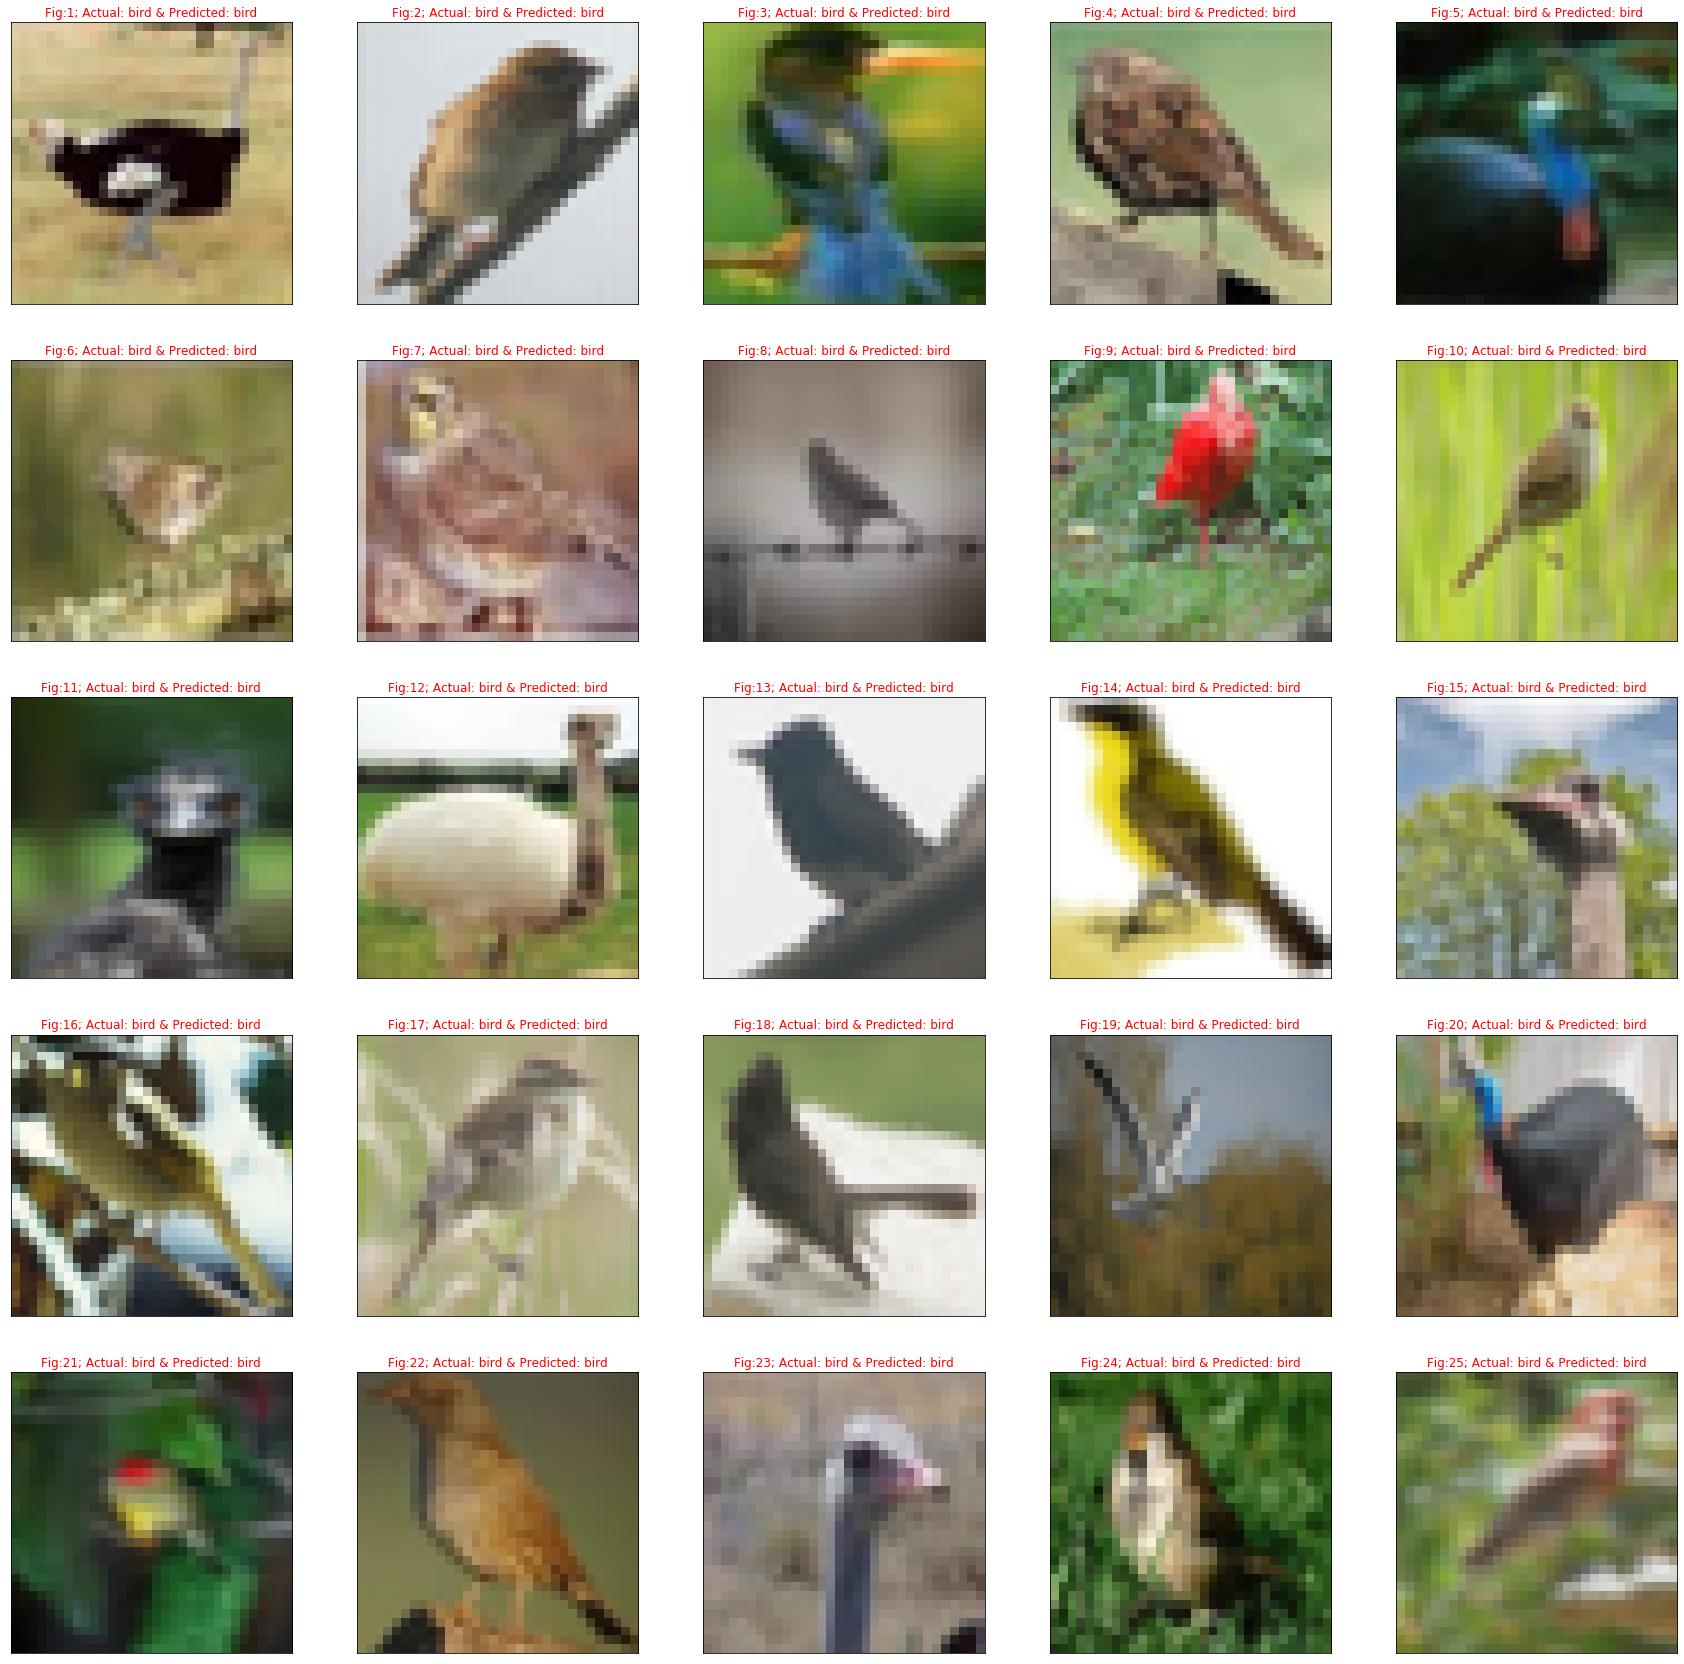

In [14]:
plot_image(test_features,test_labels,model, plot_type = "classified", img_class = "bird", num_image = 25)

In [15]:
def clear_all():
    !rm adc.json
    !rm cifar-10-python.tar.gz
    !rm colab_util.py
    !rm eval.tfrecords
    !rm generate_tfrecords.py
    !rm process_tfrecords.py
    !rm train.tfrecords
    !rm visualization.py
clear_all()

rm: cannot remove 'cifar-10-python.tar.gz': No such file or directory
rm: cannot remove 'visualization.py': No such file or directory
